In [1]:
from astropy import constants as const
print(const.R_sun.value)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
Rsol = const.R_sun.value
Lzp = 3.0128e28
import matplotlib
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 

695700000.0


In [2]:
def Mbol_cv(R, Teff):
    return -2.5 * np.log10((R**2 * Teff**4)/(Rsol**2 * 5777**4)) + 4.75
def Mbol_zp(R, Teff):
    return -2.5 * np.log10((4 * np.pi * const.sigma_sb.value * R**2 * Teff**4)/Lzp)

In [3]:
df = pd.read_csv('/home/oliver/PhD/Gaia_Project/data/KepxDR2/rcxyu18_pre_elsworth.csv')

In [4]:
Rstars = df.R_Clump * Rsol
Teffs = df.Teff

In [5]:
Mbolcv = Mbol_cv(Rstars, Teffs)
Mbolzp = Mbol_zp(Rstars, Teffs)

Diff: 0.013760516581256654


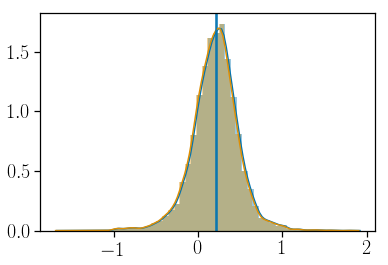

In [6]:
fig, ax = plt.subplots()
sns.distplot(Mbolcv)
ax.axvline(np.median(Mbolcv))
sns.distplot(Mbolzp)
ax.axvline(np.median(Mbolzp))

print('Diff: '+str(np.median(Mbolcv)-np.median(Mbolzp)))

plt.show()

-1.7149937272961409
-1.7253120235264157
-1.7115515069451588


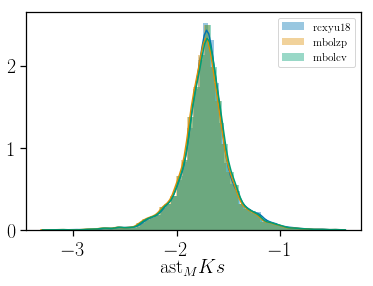

In [7]:
fig, ax = plt.subplots()
sns.distplot(df.ast_MKs, label='rcxyu18')
print(np.median(df.ast_MKs))
sns.distplot(Mbolzp - df.BC_K, label='mbolzp')
print(np.median(Mbolzp - df.BC_K))
sns.distplot(Mbolcv - df.BC_K, label='mbolcv')
print(np.median(Mbolcv - df.BC_K))
ax.legend()
plt.show()

# Lets have a look at MKs for different temperature sources

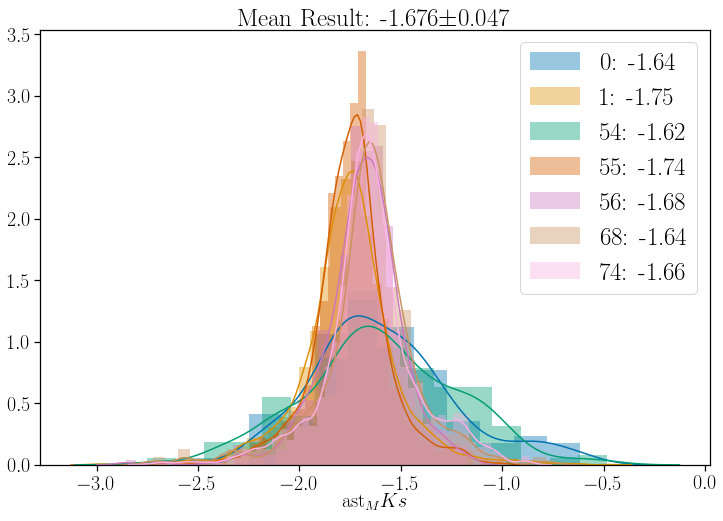

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
meds = []
for paper in np.unique(df.r_Teffi[~np.isnan(df.r_Teffi)]):
    if len(df.ast_MKs[df.r_Teffi == paper]) > 20:
        sns.distplot(df.ast_MKs[df.r_Teffi == paper], 
                     label=str(int(paper))+': '+str(np.round(np.median(df.ast_MKs[df.r_Teffi == paper]),2)))
        meds.append(np.median(df.ast_MKs[df.r_Teffi == paper]))
ax.legend(fontsize=25)
ax.set_title(r'Mean Result: '+str(np.round(np.mean(np.array(meds)),3)) + r'$\pm$'+str(np.round(np.std(np.array(meds)),3)),fontsize=25)
plt.show()

## Conclusions

The spread here is a little concerning; a simple clump magnitude from medians and stds alone finds a spread of .05 mag, which covers both our results and the literature results. Theres quite a spread within the values on a survey-by-survey basis. This does two things:
- Consolidates our results that the choice of temperature scale has a non-negligible impact on the luminosity of the clump, and
- The use of temperatures from multiple sources imposes an unquantified uncertainty (read: increased spread) on our distribution of stars around the clump luminosity

# Lets try and recalculate some BCs

In [9]:
from omnitool import bolocorr_tools

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
bc = bolocorr_tools.bolometric_correction(df.Teff, df.logg, df.Z)
BCKs = bc(band='Ks')

100%|██████████| 7630/7630 [00:03<00:00, 1917.65it/s]


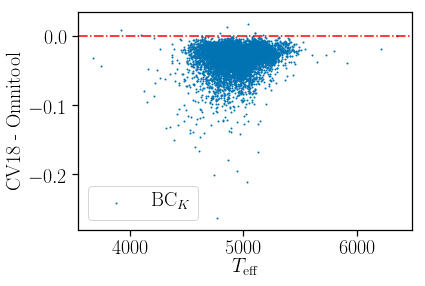

In [11]:
fig, ax = plt.subplots()
# plt.scatter(df.Teff, BCKs, label='Omnitool')
# plt.scatter(df.Teff, df.BC_K, label='CV+18')
plt.scatter(df.Teff, df.BC_K - BCKs, s=1)
plt.axhline(0., linestyle='-.', c='r')
plt.ylabel(r'CV18 - Omnitool')
plt.xlabel(r'$T_{\rm eff}$')
ax.legend(fontsize=20)
plt.show()

In [12]:
omniMks = df.Mbol - BCKs

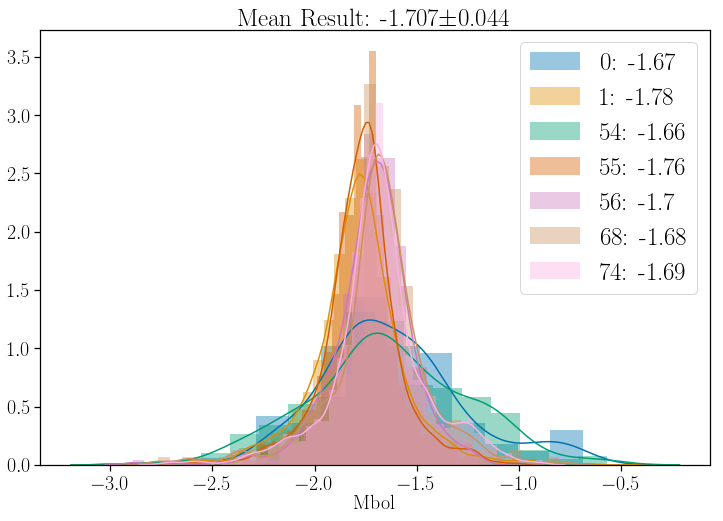

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
meds = []
for paper in np.unique(df.r_Teffi[~np.isnan(df.r_Teffi)]):
    if len(omniMks[df.r_Teffi == paper]) > 20:
        sns.distplot(omniMks[df.r_Teffi == paper], 
                     label=str(int(paper))+': '+str(np.round(np.median(omniMks[df.r_Teffi == paper]),2)))
        meds.append(np.median(omniMks[df.r_Teffi == paper]))
ax.legend(fontsize=25)
ax.set_title(r'Mean Result: '+str(np.round(np.mean(np.array(meds)),3)) + r'$\pm$'+str(np.round(np.std(np.array(meds)),3)),fontsize=25)
plt.show()

## Conclusions:
This is actually biasing our values towards lower magnitudes globally.
A similar shift in the other direction would resolve our discrepancy.

# Now lets try and recalculate the BCcodes bolocorrs

## bcgo (logg, FeH, Teff) 

In [14]:
out = df[['logg','[Fe/H]','Teff']]
out.to_csv('/home/oliver/PhD/Hacks_and_Mocks/bolometric-corrections/BCcodes/input.sample',
            sep='\t', index=False, header=False)

In [19]:
bcgo = pd.read_csv('/home/oliver/PhD/Hacks_and_Mocks/bolometric-corrections/BCcodes/output.file',
                   sep='\s+')
bcgo.rename(columns={'BC_1':'BC_Ks', 'BC_2':'BC_G'}, inplace=True)
bcgo.drop(columns=['BC_3','BC_4','BC_5'], inplace=True)

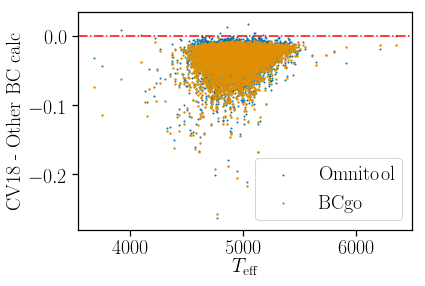

In [20]:
fig, ax = plt.subplots()
plt.scatter(df.Teff, df.BC_K - BCKs, s=1, label='Omnitool')
plt.scatter(df.Teff, df.BC_K - bcgo.BC_Ks, s=2, label='BCgo')
plt.axhline(0., linestyle='-.', c='r')
plt.ylabel(r'CV18 - Other BC calc')
plt.xlabel(r'$T_{\rm eff}$')
ax.legend(fontsize=20)
plt.show()

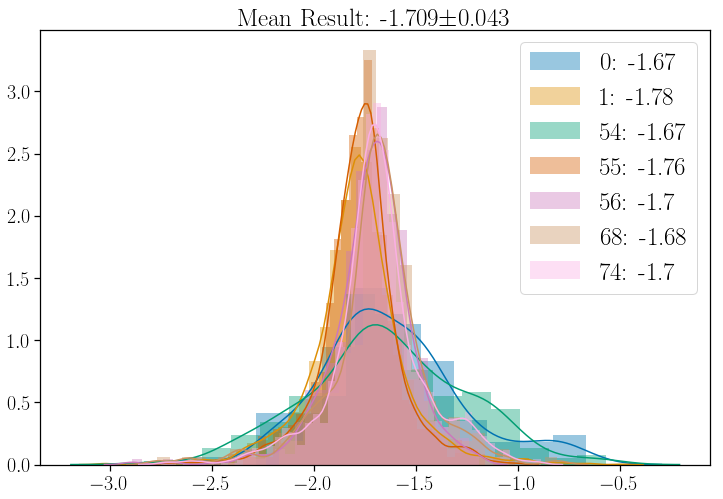

In [22]:
bcgoMks = df.Mbol - bcgo.BC_Ks

fig, ax = plt.subplots(figsize=(12,8))
meds = []
for paper in np.unique(df.r_Teffi[~np.isnan(df.r_Teffi)]):
    if len(bcgoMks[df.r_Teffi == paper]) > 20:
        sns.distplot(bcgoMks[df.r_Teffi == paper], 
                     label=str(int(paper))+': '+str(np.round(np.median(bcgoMks[df.r_Teffi == paper]),2)))
        meds.append(np.median(bcgoMks[df.r_Teffi == paper]))
ax.legend(fontsize=25)
ax.set_title(r'Mean Result: '+str(np.round(np.mean(np.array(meds)),3)) + r'$\pm$'+str(np.round(np.std(np.array(meds)),3)),fontsize=25)
plt.show()

## bcall (ID, logg, FeH, Teff, E(b-v))

In [23]:
out = df[['KICID','logg','[Fe/H]','Teff','Ebv']]
out.to_csv('/home/oliver/PhD/Hacks_and_Mocks/bolometric-corrections/BCcodes/input.sample.all',
            sep='\t', index=False, header=False)

In [26]:
bcall = pd.read_csv('/home/oliver/PhD/Hacks_and_Mocks/bolometric-corrections/BCcodes/output.file.all',
                   sep='\s+')
bcall.rename(columns={'ID':'KICID','BC_1':'bcall_BC_Ks', 'BC_2':'bcall_BC_G'}, inplace=True)
bcall.drop(columns=['BC_3','BC_4','BC_5'], inplace=True)
df = pd.merge(df, bcall[['KICID','bcall_BC_Ks']], on='KICID',how='left')

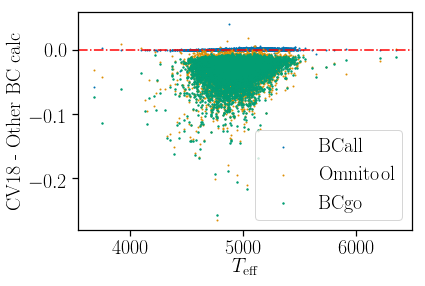

In [27]:
fig, ax = plt.subplots()
plt.scatter(df.Teff, df.BC_K - df.bcall_BC_Ks, s=1, label='BCall')
plt.scatter(df.Teff, df.BC_K - BCKs, s=1, label='Omnitool')
plt.scatter(df.Teff, df.BC_K - bcgo.BC_Ks, s=2, label='BCgo')
plt.axhline(0., linestyle='-.', c='r')
plt.ylabel(r'CV18 - Other BC calc')
plt.xlabel(r'$T_{\rm eff}$')
ax.legend(fontsize=20)
plt.show()

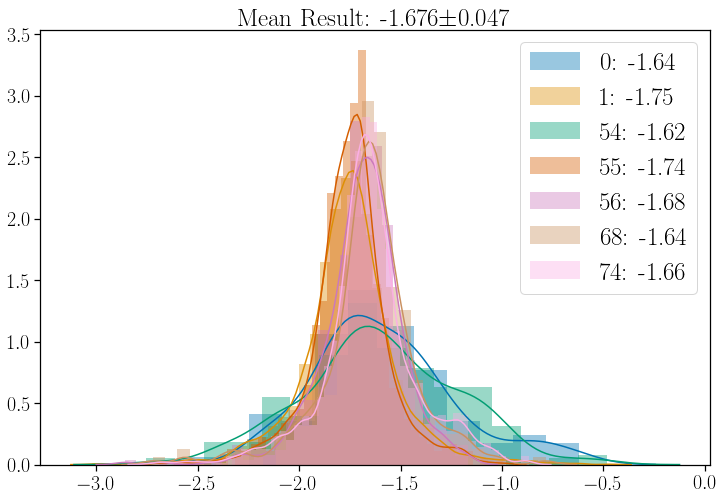

In [28]:
bcallMks = df.Mbol - df.bcall_BC_Ks

fig, ax = plt.subplots(figsize=(12,8))
meds = []
for paper in np.unique(df.r_Teffi[~np.isnan(df.r_Teffi)]):
    if len(bcallMks[df.r_Teffi == paper]) > 20:
        sns.distplot(bcallMks[df.r_Teffi == paper], 
                     label=str(int(paper))+': '+str(np.round(np.median(bcallMks[df.r_Teffi == paper]),2)))
        meds.append(np.median(bcallMks[df.r_Teffi == paper]))
ax.legend(fontsize=25)
ax.set_title(r'Mean Result: '+str(np.round(np.mean(np.array(meds)),3)) + r'$\pm$'+str(np.round(np.std(np.array(meds)),3)),fontsize=25)
plt.show()

# In Conclusion... (final)
There is no bug in the BC collecting, and cuts to parallax don't appear to make a major difference. Tests of the calculation of the bolometric magnitude using two separate methods are entirely negligible. There appears to be no systematics that clearly tell us that our data are wrong.